In [1]:
import os
os.chdir(os.environ['PROJECT_ROOT'])

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option('max.columns', 100)
pd.set_option('max.rows', 100)

# Genotype -> geolocation

In [3]:
import os
import scipy.stats as st
import folium
from geolocation.config import TARGET_AREA
from folium.plugins import HeatMap
    
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, c=False):
    m = folium.Map([54, 28], tiles='stamentoner', zoom_start=6)
    if c:
        data = data[['lat', 'long']]
    HeatMap(data, radius=10).add_to(m)
    return m

def plot_results(data, point, dt):
    m = plot_data(data)
    m.add_child(folium.Circle(*point[['lat', 'long']].values, radius=1.1e5*dt))
    return m

**Train, val, test**

In [5]:
from geolocation.config import AVAILABLE_LOCI, DATASETS

X_train = pd.read_excel(DATASETS['train'])
X_val = pd.read_excel(DATASETS['val'])
X_test = pd.read_excel(DATASETS['test'])

X_train.shape, X_val.shape, X_test.shape

((1169, 41), (62, 41), (65, 41))

In [143]:
from geolocation.geolocation import Geolocator, AVAILABLE_GEOLOCATORS
from geolocation.distance import D
from geolocation.metrics import collect_q_metrics, collect_test_metrics

In [179]:
def get_gdlink_params(gdlink_params, dt, k):
    return dict(zip(
        filter(lambda x: '_' in x, gdlink_params.columns.values),
        gdlink_params.query(f'(dt == {dt}) & (k == {k})').values.tolist()[0][3:]
    ))

In [181]:
from sklearn.model_selection import ShuffleSplit
from itertools import product
import tqdm

def cv_estimation(dt, k, method, train_data, folds=20, plots=5, cg_params={}, rg_params={}):
    results = []
    ss = ShuffleSplit(n_splits=folds, test_size=0.1, random_state=0)
    for train_index, test_index in ss.split(train_data):
        X_cv_train = X_train.iloc[train_index].reset_index()
        X_cv_test = X_train.iloc[test_index].reset_index()
        bc = AVAILABLE_GEOLOCATORS[method](X_cv_train, cg_params, rg_params).batch_locate(X_cv_test, k)
        results.append(pd.DataFrame(collect_test_metrics(dt, k, X_cv_test, bc)).T)
    
    for i in range(plots):
        if i == plots:
            break
        display(plot_results(bc[i], X_cv_test.iloc[i:i+1].reset_index(), dt))
    
    results = pd.concat(results).reset_index(drop=True)
    return results


DT = [0.1, 0.3, 0.5, 1]
K = [1, 3, 5, 10, 15, 20]
METHOD = ['random', 'best_match', 'greedy', 'gdlink']

global_results = dict()
for dt, k, method in tqdm.tqdm_notebook(product(DT, K, METHOD)):
    print(dt, k, method)
    if method == 'gdlink':
        rg_params = get_gdlink_params(gdlink_params, dt, k)
    else:
        rg_params = {}
        
    global_results[f'{dt}_{k}_{method}'] = cv_estimation(dt, k, method, X_train, 20, 0, rg_params=rg_params)

c:\users\dzmitry_dzemidka\appdata\local\continuum\anaconda3\envs\genomics\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0.1 1 random
0.1 1 best_match
0.1 1 greedy
0.1 1 gdlink
0.1 3 random
0.1 3 best_match
0.1 3 greedy
0.1 3 gdlink
0.1 5 random
0.1 5 best_match
0.1 5 greedy
0.1 5 gdlink
0.1 10 random
0.1 10 best_match
0.1 10 greedy
0.1 10 gdlink
0.1 15 random
0.1 15 best_match
0.1 15 greedy
0.1 15 gdlink
0.1 20 random
0.1 20 best_match
0.1 20 greedy
0.1 20 gdlink
0.3 1 random
0.3 1 best_match
0.3 1 greedy
0.3 1 gdlink
0.3 3 random
0.3 3 best_match
0.3 3 greedy
0.3 3 gdlink
0.3 5 random
0.3 5 best_match
0.3 5 greedy
0.3 5 gdlink
0.3 10 random
0.3 10 best_match
0.3 10 greedy
0.3 10 gdlink
0.3 15 random
0.3 15 best_match
0.3 15 greedy
0.3 15 gdlink
0.3 20 random
0.3 20 best_match
0.3 20 greedy
0.3 20 gdlink
0.5 1 random
0.5 1 best_match
0.5 1 greedy
0.5 1 gdlink
0.5 3 random
0.5 3 best_match
0.5 3 greedy
0.5 3 gdlink
0.5 5 random
0.5 5 best_match
0.5 5 greedy
0.5 5 gdlink
0.5 10 random
0.5 10 best_match
0.5 10 greedy
0.5 10 gdlink
0.5 15 random
0.5 15 best_match
0.5 15 greedy
0.5 15 gdlink
0.5 20 random
0.

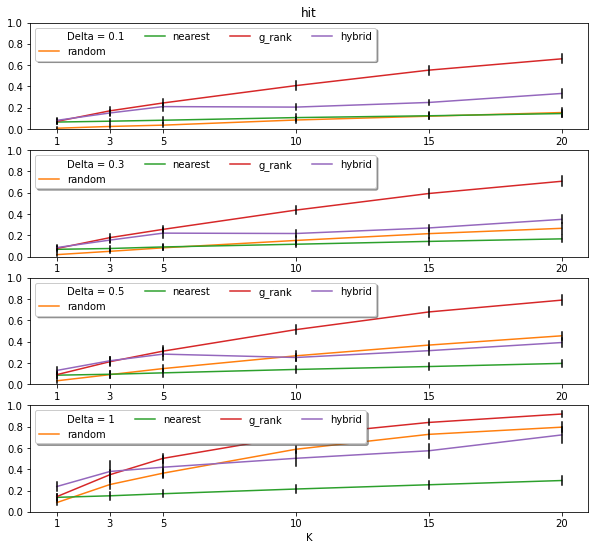

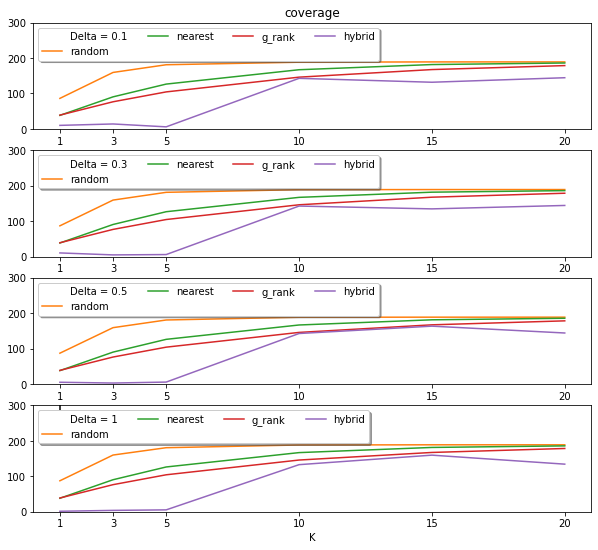

In [184]:
from matplotlib import pyplot as plt

NAMES = dict(zip(METHOD, ['random', 'nearest', 'g_rank', 'hybrid']))

def plot_metric(global_results, metric, ylim):
    fig = plt.figure(figsize=(10, 9))
    axs = []
    for i in range(len(DT)):
        ax = plt.subplot2grid((len(DT), 1), (i,0), sharex=None if i == 0 else axs[0])
        axs.append(ax)
    
    for p, dt in enumerate(DT):
        ax = axs[p]
        ax.plot([], [], ' ', label=f'Delta = {dt}')

        ax.set_xlim([0, 21])
        ax.set_ylim(ylim)

        for method in METHOD:
            means = np.array([global_results[f'{dt}_{k}_{method}'][f'{metric}@{k}_{dt}'].mean() for k in K])
            stds = np.array([global_results[f'{dt}_{k}_{method}'][f'{metric}@{k}_{dt}'].std() for k in K])
            y_min = means - stds
            y_max = means + stds
            
            ax.plot(K, means, label=NAMES[method])
            
            for i, k in enumerate(K):
                ax.axvline(x=k, ymin=y_min[i], ymax=y_max[i], color='black')
            
        ax.legend(loc='upper left', shadow=True, ncol=4)
        ax.xaxis.set_ticks(K) 
        ax.set_xlabel('K') 



    fig.subplots_adjust(hspace=0.2)   
    axs[0].set_title(metric)

    plt.show()


plot_metric(global_results, 'hit', [0, 1])
plot_metric(global_results, 'coverage', [0, 300])

# Bayes opt

In [149]:
from functools import partial

def F(train, dt, k, **params):
    cv_results = cv_estimation(dt, k, 'gdlink', train, folds=10, plots=0, cg_params={}, rg_params=params)
    target = cv_results[f'hit@{k}_{dt}'].mean()
    cov = cv_results[f'coverage@{k}_{dt}'].mean()
    if k > 5 and cov < 130:
        target = target / 2
    return target

def get_F(train, dt, k):
    return partial(F, train=train, dt=dt, k=k)

In [151]:
from bayes_opt import BayesianOptimization
from functools import partial
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from geolocation.candidates_ranking import RankingGeneratorGDLinkage

**Bopt**

In [153]:
for dt in DT:
    print(f"DT = {dt}")
    for k in K:
        print(f'K = {k}')
        optimizer = BayesianOptimization(
            f=get_F(X_train, dt, k),
            pbounds=RankingGeneratorGDLinkage(X_train).get_params(),
            verbose=2,
            random_state=1,
        )
        dt_str = f'{dt}'.replace('.', '')
        log_file = f'data/bayes_opt_logs/b_opt_log_dt_{dt_str}_k_{k}.json'
        logger = JSONLogger(path=log_file)
        optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
        
        optimizer.maximize(
            init_points=50,
            n_iter=100,
        )
        print(optimizer.max)

DT = 0.1
K = 1
{'target': 0.08717948717948719, 'params': {'d_alpha': 1.0358964059155116, 'd_t': 0.19913839356593663, 'g_mean': 0.5089334672349852, 'g_std': 9.50135280391732, 'g_t': 0.17596651215059786}}
K = 3
{'target': 0.15128205128205133, 'params': {'d_alpha': 1.3287251427566547, 'd_t': 0.11088444912796892, 'g_mean': 0.6815098812187688, 'g_std': 5.032219333074789, 'g_t': 0.11887024580057975}}
K = 5
{'target': 0.21196581196581196, 'params': {'d_alpha': 0.9658266586271199, 'd_t': 0.2239627006727206, 'g_mean': 0.5481023876778228, 'g_std': 2.2063145302715927, 'g_t': 0.22343290882359182}}
K = 10
{'target': 0.20598290598290597, 'params': {'d_alpha': 1.320289758313735, 'd_t': 0.06963364440487509, 'g_mean': 0.5912197354182295, 'g_std': 5.755297592364942, 'g_t': 0.27855952054731375}}
K = 15
{'target': 0.25384615384615383, 'params': {'d_alpha': 0.997473881395359, 'd_t': 0.18544680531189853, 'g_mean': 0.5249776474521098, 'g_std': 9.373526502170227, 'g_t': 0.2528083471574494}}
K = 20
{'target': 

# Evaluate

In [157]:
import os
import json


results = []
for dt in DT:
    for k in K:
        dt_str = f'{dt}'.replace('.', '')
        log_file = f'data/bayes_opt_logs/b_opt_log_dt_{dt_str}_k_{k}.json'

        probes = []
        with open(log_file, 'r') as f:
            for line in f:
                probe = json.loads(line)
                probes.append(probe)
        best_probe = sorted(probes, key=lambda x: x['target'], reverse=True)[0]

        result = pd.DataFrame({'dt': [dt], 'k': [k], 'target': [best_probe['target']],
                               **{k: [v] for k, v in best_probe['params'].items()}})
    
        results.append(result)

gdlink_params = pd.concat(results).reset_index(drop=True)

In [40]:
# import json

# def generate_example(row, k):
#     genotype = row[AVAILABLE_LOCI].sample(k).astype('float')
#     print(genotype)
#     return {
#         'meta_data': dict(row[['population', 'id', 'region', 'lat', 'long']]),
#         'genotype': dict(genotype)
#     }
    
    
# with open("data/apps/geolocation/sample3.json", "w") as write_file:
#     json.dump(generate_example(examples.iloc[2], 30), write_file)